In [ ]:
import os


import numpy as np
import pandas as pd
import tensorflow.keras.backend as K
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import Regularizer
from tensorflow.python.keras.layers import BatchNormalization, GRU

In [ ]:
def load_data():
    # Default values.
    train_set = 'data/UNSW_NB15_training-set.csv'
    test_set = 'data/UNSW_NB15_testing-set.csv'
    train = pd.read_csv(train_set, index_col='id')  # 指定“id”这一列数据作为行索引
    test = pd.read_csv(test_set, index_col='id')  # 指定“id”这一列数据作为行索引

    # 二分类数据
    training_label = train['label'].values  # 将train的“label”这一列的值单独取出来
    testing_label = test['label'].values  # 将test的“label”这一列的值单独取出来
    temp_train = training_label
    temp_test = testing_label

    # Creates new dummy columns from each unique string in a particular feature 创建新的虚拟列
    unsw = pd.concat([train, test])  # 将train和test拼接在一起
    unsw = pd.get_dummies(data=unsw,
                          columns=['proto', 'service', 'state'])  # 将'proto', 'service', 'state'这三列使用one-hot-encoder转变
    # Normalising all numerical features:
    unsw.drop(['label', 'attack_cat'], axis=1,
              inplace=True)  # 删除'label', 'attack_cat'这两列，其中(inplace=True)是直接对原dataFrame进行操作
    unsw_value = unsw.values

    scaler = MinMaxScaler(feature_range=(0, 1))  # 初始化MinMaxScaler
    unsw_value = scaler.fit_transform(unsw_value)  # 将待处理数据矩阵进行归一化
    train_set = unsw_value[:len(train), :]  # 分离出train集
    test_set = unsw_value[len(train):, :]  # 分离出test集

    # return train_set, training_label, test_set, testing_label
    return train_set, temp_train, test_set, temp_test


In [ ]:



class Sparse(Regularizer):
    def __init__(self, rho=0.005, alpha=10):
        self.rho = rho
        self.alpha = alpha

    def __call__(self, x):
        rho_hat = K.mean(x)
        regularization = self.rho * K.log(self.rho / rho_hat) + (1 - self.rho) * K.log((1 - self.rho) / (1 - rho_hat))
        return self.alpha * regularization

    def get_config(self):
        return {'rho:': float(self.rho),
                'alpha': float(self.alpha)
                }

def build_SAE(rho=0.05):

    # first step is to define a sSAE and pre-training
    # Layer 1
    input_traffic = Input(shape=(196, ))
    distorted_input1 = Dropout(0.1)(input_traffic)
    encoded_1 = Dense(128, activation='relu', activity_regularizer=Sparse(rho))(distorted_input1)
    encoded_1_bn = BatchNormalization()(encoded_1)
    decoded_1 = Dense(196, activation='relu', activity_regularizer=Sparse(rho))(encoded_1_bn)

    autoendoder_1 = Model(inputs=input_traffic, outputs=decoded_1)
    encoder_1 = Model(inputs=input_traffic, outputs=encoded_1_bn)

    # Layer 2
    encoded1_input = Input(shape=(128, ))
    distorted_input2 = Dropout(0.1)(encoded1_input)
    encoded_2 = Dense(32, activation='relu', activity_regularizer=Sparse(rho))(distorted_input2)
    encoded_2_bn = BatchNormalization()(encoded_2)
    decoded_2 = Dense(128, activation='relu', activity_regularizer=Sparse(rho))(encoded_2_bn)

    autoendoder_2 = Model(inputs=encoded1_input, outputs=decoded_2)
    encoder_2 = Model(inputs=encoded1_input, outputs=encoded_2_bn)

    # Layer 3
    encoded2_input = Input(shape=(32, ))
    distorted_input3 = Dropout(0.1)(encoded2_input)
    encoded_3 = Dense(32, activation='relu', activity_regularizer=Sparse(rho))(distorted_input3)
    encoded_3_bn = BatchNormalization()(encoded_3)
    decoded_3 = Dense(32, activation='relu', activity_regularizer=Sparse(rho))(encoded_3_bn)

    autoendoder_3 = Model(inputs=encoded2_input, outputs=decoded_3)
    encoder_3 = Model(inputs=encoded2_input, outputs=encoded_3_bn)

    optimize_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    autoendoder_1.compile(loss='mse', optimizer=optimize_1)
    encoder_1.compile(loss='mse', optimizer=optimize_1)

    optimize_2 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    autoendoder_2.compile(loss='mse', optimizer=optimize_2)
    encoder_2.compile(loss='mse', optimizer=optimize_2)

    optimize_3 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    autoendoder_3.compile(loss='mse', optimizer=optimize_3)
    encoder_3.compile(loss='mse', optimizer=optimize_3)

    model_input = Input(shape=(196,))
    model_encoded_1 = Dense(128, activation='relu')(model_input)
    model_encoded1_bn = BatchNormalization()(model_encoded_1)
    model_encoded_2 = Dense(32, activation='relu')(model_encoded1_bn)
    model_encoded2__bn = BatchNormalization()(model_encoded_2)
    model_encoded_3 = Dense(32, activation='relu')(model_encoded2__bn)
    model_encoded3__bn = BatchNormalization()(model_encoded_3)

    model_decoded_3 = Dense(32, activation='relu')(model_encoded3__bn)
    model_decoded_2 = Dense(128, activation='relu')(model_decoded_3)
    model_decoded_1 = Dense(196, activation='relu')(model_decoded_2)

    ae_model = Model(inputs=model_input, outputs=model_decoded_1)
    ae_encoder = Model(inputs=model_input, outputs=model_encoded3__bn)
    optimize = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    ae_model.compile(loss='mse', optimizer=optimize)

    # second step is to define a classifier and fine-tuning


    return autoendoder_1, encoder_1, autoendoder_2, encoder_2, autoendoder_3, encoder_3, ae_model, ae_encoder

In [ ]:
# load data
print("Load data...")
train, train_label, test, test_label = load_data()
print("train shape: ", train.shape)
train_label = train_label.reshape((-1, 1))
test_label = test_label.reshape((-1, 1))
print("train_label shape: ", train_label.shape)

# build model
print("Build AE model")
autoencoder_1, encoder_1, autoencoder_2, encoder_2, autoencoder_3, encoder_3, sSAE, sSAE_encoder = build_SAE(rho=0.04)

print("Start pre-training....")

# fit the first layer, 在此处添加validation_data=test，加上callbacks，记录的是val_loss，取最小的那个
print("First layer training....")
AE_1_dir = os.path.join(os.getcwd(), 'saved_ae_1')
ae_1_filepath="best_ae_1.hdf5"
ae_1_point = ModelCheckpoint(os.path.join(AE_1_dir, ae_1_filepath), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ae_1_stops = EarlyStopping(monitor='val_loss', patience=10, mode='min')
autoencoder_1.fit(train, train, epochs=100, batch_size=1024, validation_data=(test, test), verbose=0, shuffle=True, callbacks=[ae_1_point, ae_1_stops])

autoencoder_1.load_weights('./saved_ae_1/best_ae_1.hdf5')
first_layer_output = encoder_1.predict(train)  # 在此使用loss最小的那个模型
test_first_out = encoder_1.predict(test)
print("The shape of first layer output is: ", first_layer_output.shape)

# fit the second layer
print("Second layer training....")
AE_2_dir = os.path.join(os.getcwd(), 'saved_ae_2')
ae_2_filepath="best_ae_2.hdf5"
ae_2_point = ModelCheckpoint(os.path.join(AE_2_dir, ae_2_filepath), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ae_2_stops = EarlyStopping(monitor='val_loss', patience=10, mode='min')
autoencoder_2.fit(first_layer_output, first_layer_output, epochs=100, batch_size=512, verbose=0, validation_data=(test_first_out, test_first_out), shuffle=True, callbacks=[ae_2_point, ae_2_stops])

autoencoder_2.load_weights('./saved_ae_2/best_ae_2.hdf5')
second_layer_output = encoder_2.predict(first_layer_output)
test_second_out = encoder_2.predict(test_first_out)
print("The shape of second layer output is: ", second_layer_output.shape)

# fit the third layer
print("Third layer training....")
AE_3_dir = os.path.join(os.getcwd(), 'saved_ae_3')
ae_3_filepath="best_ae_3.hdf5"
ae_3_point = ModelCheckpoint(os.path.join(AE_3_dir, ae_3_filepath), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
ae_3_stops = EarlyStopping(monitor='val_loss', patience=10, mode='min')
autoencoder_3.fit(second_layer_output, second_layer_output, epochs=100, batch_size=512, verbose=0, validation_data=(test_second_out, test_second_out), shuffle=True, callbacks=[ae_3_point, ae_3_stops])
autoencoder_3.load_weights('./saved_ae_3/best_ae_3.hdf5')

print("Pass the weights to sSAE_encoder...")
sSAE_encoder.layers[1].set_weights(autoencoder_1.layers[2].get_weights())  # first Dense
sSAE_encoder.layers[2].set_weights(autoencoder_1.layers[3].get_weights())  # first BN
sSAE_encoder.layers[3].set_weights(autoencoder_2.layers[2].get_weights())  # second Dense
sSAE_encoder.layers[4].set_weights(autoencoder_2.layers[3].get_weights())  # second BN
sSAE_encoder.layers[5].set_weights(autoencoder_3.layers[2].get_weights())  # third Dense
sSAE_encoder.layers[6].set_weights(autoencoder_3.layers[3].get_weights())  # third BN

encoded_train = sSAE_encoder.predict(train)
encoded_test = sSAE_encoder.predict(test)

np.save('data/encoded_train.npy', encoded_train)
np.save('data/train_label.npy', train_label)
np.save('data/encoded_test.npy', encoded_test)
np.save('data/test_label.npy', test_label)

# 级联两层Dense 最后加一个softmax
mlp0 = Dense(units=32, activation='relu')(sSAE_encoder.output)
lstm_reshape = Reshape((1, 32))(mlp0)

lstm = LSTM(units=16, activation='tanh', return_sequences=False)(lstm_reshape)
lstm_drop = Dropout(0.3)(lstm)

mlp = Dense(units=10, activation='relu')(lstm_drop)
mlp2 = Dense(units=1, activation='sigmoid')(mlp)


classifier = Model(sSAE_encoder.input, mlp2)
optimize = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
classifier.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['accuracy'])

save_dir = os.path.join(os.getcwd(), 'saved_models_temp')
filepath="best_model.hdf5"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=True,
                         write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
reduc_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=10, mode='max', factor=0.2, epsilon=0.0001)

history = classifier.fit(train, train_label, epochs=100, batch_size=1024, validation_data=(test, test_label), callbacks=[checkpoint, tbCallBack, reduc_lr], verbose=2)
classifier.load_weights('saved_models_temp/best_model.hdf5')

# 保存下最好的模型，然后重新构建一个模型，毕竟这里只是一个预训练的过程。
# 然后，在后面的过程中，首先使用的AE，并且对结果进行TimesereisGenerator
# 最后，输入到LSTM中实现分类。
train_y = classifier.predict(train)
train_pred = train_y > 0.5

test_y = classifier.predict(test)
test_pred = test_y > 0.5

print(confusion_matrix(train_label, train_pred))
print(confusion_matrix(test_label, test_pred))


In [ ]:

# 加载数据

train_all = np.load('data/encoded_train.npy')  # (175341, 32)
train_all_label = np.load('data/train_label.npy')  # (175341, 1)
test_all = np.load('data/encoded_test.npy')
test_all_label = np.load('data/test_label.npy')

# 利用TimesereisGenerator生成序列数据
time_steps = 8
batch_size = 1024

# 先把训练集划分出一部分作为验证集
train = train_all[:(172032 + time_steps), :]  # 4096 * 42 = 172032
train_label = train_all_label[:(172032 + time_steps), :]
test = test_all[:(81920 + time_steps), :]  # 4096 * 20 = 81920
test_label = test_all_label[:(81920 + time_steps), :]
# val_data = train_all[int(len(train_all)* 0.7):, :]
# val_label = train_all_label[int(len(train_all)* 0.7):, :]
# print(train.shape[0])
# print(val_data.shape[0])
# 数据集生成器
train_label_ = np.insert(train_label, 0, 0, axis=0)
test_label_ = np.insert(test_label, 0, 0, axis=0)
# val_label_ = np.insert(val_label, 0, 0)
train_generator = TimeseriesGenerator(train, train_label_[:-1], length=time_steps, sampling_rate=1,
                                      batch_size=batch_size)
test_generator = TimeseriesGenerator(test, test_label_[:-1], length=time_steps, sampling_rate=1, batch_size=batch_size)
# val_generator = TimeseriesGenerator(val_data, val_label_[:-1], length=time_steps, sampling_rate=1, batch_size=batch_size)

# 构造模型
# input_traffic = Input((time_steps, 32))
input_traffic = Input(shape=(time_steps, 32))
# 1 lstm layer, stateful=True

# GRU/LSTM
GRU1=Bidirectional(GRU(units=24, activation='tanh',
                           return_sequences=True, recurrent_dropout=0.1))(input_traffic)
GRU_drop1 = Dropout(0.5)(GRU1)

GRU2=Bidirectional(GRU(units=12, activation='tanh',
                           return_sequences=False, recurrent_dropout=0.1))(GRU_drop1)
GRU_drop2 = Dropout(0.5)(GRU2)
'''lstm1 = Bidirectional(LSTM(units=24, activation='tanh',
                           return_sequences=True, recurrent_dropout=0.1))(input_traffic)
lstm_drop1 = Dropout(0.5)(lstm1)
# 2 lstm layer, stateful=True
lstm2 = Bidirectional(LSTM(units=12, activation='tanh', return_sequences=False,
                           recurrent_dropout=0.1))(lstm_drop1)
lstm_drop2 = Dropout(0.5)(lstm2)'''
# lstm3 = Bidirectional(LSTM(units=8, activation='tanh', return_sequences=False,
#                            recurrent_dropout=0.1))(lstm_drop2)
# lstm_drop2 = Dropout(0.5)(lstm_drop1)
# mlp
mlp = Dense(units=6, activation='relu')(GRU_drop2)
mlp2 = Dense(units=1, activation='sigmoid')(mlp)
classifier = Model(input_traffic, mlp2)
optimize = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
classifier.compile(optimizer=optimize, loss='binary_crossentropy', metrics=['accuracy'])

# 设置一些callbacks
save_dir = os.path.join(os.getcwd(), 'models')
filepath = "best_model.hdf5"
checkpoint = ModelCheckpoint(os.path.join(save_dir, filepath), monitor='val_accuracy', verbose=1, save_best_only=True,
                             mode='max')
tbCallBack = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_grads=True,
                         write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
reduc_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=10, mode='max', factor=0.2, min_delta=0.0001)

# 拟合及预测
history = classifier.fit_generator(train_generator, epochs=40, verbose=2, steps_per_epoch=168,
                                   callbacks=[checkpoint, tbCallBack, reduc_lr],
                                   validation_data=test_generator, shuffle=0, validation_steps=80)

classifier.load_weights('./models/best_model.hdf5')
train_probabilities = classifier.predict_generator(train_generator, verbose=1)

train_pred = train_probabilities > 0.5
train_label_original = train_label_[(time_steps - 1):-2, :]

test_probabilities = classifier.predict_generator(test_generator, verbose=1)
test_pred = test_probabilities > 0.5
test_label_original = test_label_[(time_steps - 1):-2, ]
np.save('data/plot_prediction.npy', test_pred)
np.save('data/plot_original.npy', test_label_original)
# tn, fp, fn, tp = confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0]).ravel()
from sklearn.metrics import confusion_matrix, classification_report

print('Trainset Confusion Matrix')
print(confusion_matrix(train_label_original, train_pred))
print('Testset Confusion Matrix')
print(confusion_matrix(test_label_original, test_pred))
print('Classification Report')

print(classification_report(test_label_original, test_pred))

(80065, 2)
(1855, 2)


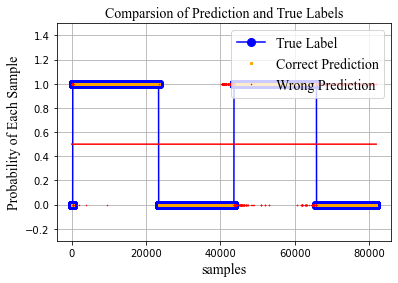

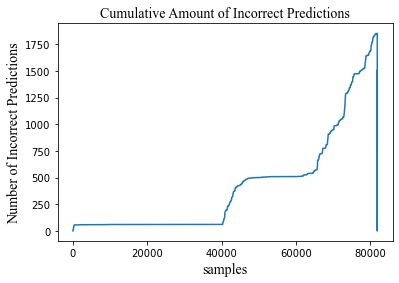

In [7]:
import numpy as np
import matplotlib.pyplot as plt
# 本程序是用于绘制出测试数据的判决情况，并采用一个相似度来衡量
# 参考网址：https://matplotlib.org/gallery/recipes/transparent_legends.html#sphx-glr-gallery-recipes-transparent-legends-py
# https://matplotlib.org/gallery/lines_bars_and_markers/cohere.html#sphx-glr-gallery-lines-bars-and-markers-cohere-py
# 用蓝色表示原始的数据，用橙色表示预测的数据，其中预测若出现失误，则对应点采用的是红色的，即共有三种颜色。
# 第二幅图画出的是预测错误的累计个数


# Two signals with a coherent part at 10Hz and a random part
s1 = np.load('data/plot_original.npy')
s2 = np.load('data/plot_prediction.npy')
test_pred = s2 > 0.5
index_same = np.argwhere(s1 == test_pred)
index_diff = np.argwhere(s1 != test_pred)

print(index_same.shape)
print(index_diff.shape)
dt = 1.0
t = np.arange(0, len(s1), dt)
s3 = np.ones(len(s1)) * 0.5
fig = plt.figure(1)
ax1 = fig.add_subplot(111)

font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 14,
         }
font2 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 14,
         }
ax1.plot(t, s1, markersize=8, label='True Label', color='blue', marker='o', linestyle='-')
ax1.plot(t[index_same[:, 0]], s2[index_same[:, 0]], markersize=2, label='Correct Prediction', color='orange',
         marker='s', linestyle='')
ax1.plot(t[index_diff[:, 0]], s2[index_diff[:, 0]], markersize=0.5, label='Wrong Prediction', color='red', marker='s',
         linestyle='')
ax1.plot(t, s3, 'r-')
ax1.set_ylim(-0.3, 1.5)
ax1.set_xlabel('samples', font2)
ax1.set_ylabel('Probability of Each Sample', font2)
ax1.legend(loc='upper right', prop=font2)
plt.title('Comparsion of Prediction and True Labels', font1)
ax1.grid(True)
plt.show()
# 画出累计
fig2 = plt.figure(1)
ax2 = fig2.add_subplot(111)
count_line = np.zeros(len(s1))
index_low = 0
index_high = 0
for i, index in enumerate(index_diff):
    index_high = index[0]
    count_line[index_low:index_high] = i
    index_low = index_high
count_line[81918:] = 1506
ax2.plot(t, count_line)
plt.title('Cumulative Amount of Incorrect Predictions', font1)
ax2.set_xlabel('samples', font2)
ax2.set_ylabel('Number of Incorrect Predictions', font2)


plt.show()
